In [1]:
# Imports
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import pickle
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from scipy.ndimage.measurements import label

from utils import slide_window, extract_features_single, add_heat,\
                  draw_boxes, find_cars, read_img, draw_labelled_bboxes

from IPython.core import debugger

In [2]:
# To save as normal python script (easier to git diff)
# !jupyter nbconvert --to script pipeline.ipynb

In [3]:
# Load test images (RGB)
test_image_paths = glob.glob('test_images/test*.jpg')
test_images = [read_img(file, 'cv2') for file in test_image_paths]

In [4]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, config):
    on_windows = []

    for window in windows:
        window_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        
        features = extract_features_single(window_img, **config)

        test_features = scaler.transform(np.array(features).reshape(1, -1))
        prediction = clf.predict(test_features)

        if prediction == 1:
            on_windows.append(window)

    return on_windows

In [5]:
svc = pickle.load(open('svc_classifier.pkl', 'rb'))
config = pickle.load(open('feature_config.pkl', 'rb'))
X_scaler = pickle.load(open('x_scaler.pkl', 'rb'))

/Users/robertmoss/Code/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


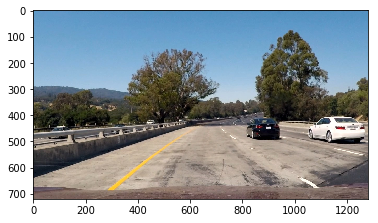

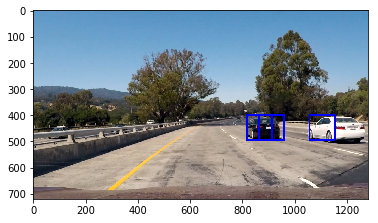

In [6]:
test_img = test_images[0]
draw_image = np.copy(test_img)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

windows = slide_window(test_img,
                       x_start_stop=[None, None],
                       y_start_stop=[400, 700],
                       xy_window=(96, 96),
                       xy_overlap=(0.5, 0.5))

hot_windows = search_windows(test_img, windows, svc, X_scaler, config)
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)


plt.imshow(test_img)
plt.figure()
plt.imshow(window_img)
plt.show()

8
2
[1.0, 1.5, 2.0]


/Users/robertmoss/Code/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


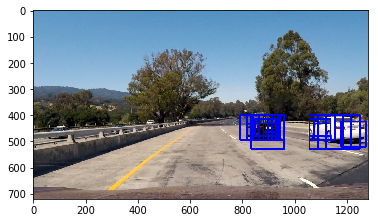

In [7]:
xy_window=(96, 96)
xy_window=(64, 64)
xy_overlap=(0.75, 0.75)

cells_per_window = int(xy_window[0] / config['pix_per_cell'])
cells_per_step = int((1 - xy_overlap[0]) * cells_per_window)
print(cells_per_window)
print(cells_per_step)

window_sizes = [
    (64, 64),
    (96, 96),
    (128, 128)
]
scales = [ws[0]/xy_window[0] for ws in window_sizes]
print(scales)
# scales = [1, 1.5, 2]
# cells_per_step = 2
# print(cells_per_step)

hot_windows = []
for scale in scales:
    hot_windows.extend(find_cars(test_img, y_start_stop=[400, 700], scale=scale,
                                 svc=svc, X_scaler=X_scaler, **config))

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)

plt.imshow(window_img)
plt.show()

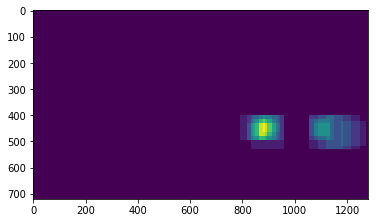

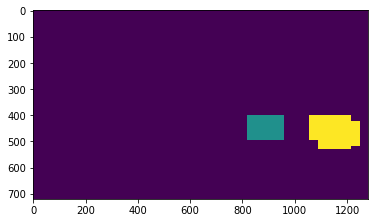

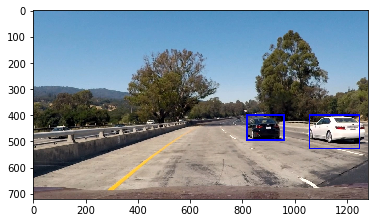

In [18]:
# Heatmap
heatmap = np.zeros_like(test_img[:,:,0]).astype(np.float)
add_heat(heatmap, hot_windows)

plt.imshow(heatmap)
plt.show()

# Apply a threshold to the heatmap
heatmap[heatmap <= 1] = 0

labelled_array, num_features = label(heatmap)
plt.imshow(labelled_array)
plt.show()

output = draw_labelled_bboxes(test_img, (labelled_array, num_features), color=(0, 0, 255), thick=6)
plt.imshow(output)
plt.show()